### Evaluation 

This notebook is meant to serve as an example for how to evaluate the performance of a trained model, and/or compare to the summation of Q_prime for your inputs. Summed Q` represents using a summation rather than routing and is a good indicator of the baseline performance of your model

In [1]:
# Run imports
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml

from ddr._version import __version__
from ddr.validation import (
    Config,
    Metrics,
    plot_box_fig,
    plot_cdf,
    plot_drainage_area_boxplots,
    plot_gauge_map,
)

log = logging.getLogger(__name__)

In [ ]:
# # Load a config
# config_path = "../"
# with open("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250901-train/hbv-test-2025-09-02_02-33-05/pydantic_config.yaml") as f:
#     config = Config(**yaml.safe_load(f))

In [2]:
MODEL_NAME = "Ensemble" #"δPRMS2.0"
# Loading paths to results. We're comparing to summed q_prime as it's a good indicator of if routing is working
summed_q_prime_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/ensemble_qsum-2025-09-04_19-52-09/summed_q_prime.zarr")  # To obtain this, please run scripts/summed_q_prime.py
# summed_q_prime_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/hbv_qsum-2025-09-04_19-57-52/summed_q_prime.zarr")  # hbv
# summed_q_prime_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/prms_qsum-2025-09-04_19-56-54/summed_q_prime.zarr")  # prms
# summed_q_prime_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/hbv-2025-09-02_08-50-20/summed_q_prime.zarr") 


predictions_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/ensemble_test-2025-09-04_19-31-47/model_test.zarr")  # To obtain this, please run scripts/ to evaluate a trained model
# predictions_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/hbv_test-2025-09-04_19-37-53/model_test.zarr")  # hbv
# predictions_path = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/v2_gages2700/prms_test-2025-09-04_19-36-04/model_test.zarr")  # prms


ds_qp = xr.open_zarr(summed_q_prime_path)
ds_pred = xr.open_zarr(predictions_path)
ds_qp

<xarray.Dataset> Size: 118MB
Dimensions:       (gage_ids: 2681, time: 5479)
Coordinates:
  * gage_ids      (gage_ids) object 21kB '01011000' '01013500' ... '14400000'
  * time          (time) datetime64[ns] 44kB 1995-10-01 ... 2010-09-30
Data variables:
    predictions   (gage_ids, time) float32 59MB dask.array<chunksize=(336, 685), meta=np.ndarray>
    observations  (gage_ids, time) float32 59MB dask.array<chunksize=(336, 685), meta=np.ndarray>
Attributes:
    description:             Summed Q` predictions and observations
    start time:              1995-10-01
    end time:                2010-09-30
    version:                 0.1.dev146+g192c9f188.d20250902
    evaluation basins file:  /projects/mhpi/leoglonz/multiscale/routing/ddr/o...
    data source:             /projects/mhpi/leoglonz/multiscale/output/forwar...
    model:                   /projects/mhpi/leoglonz/multiscale/routing/ddr/o...

In [3]:
# Get Metrics
results = []

ds_qp_ordered = ds_qp.sel(gage_ids=ds_pred.gage_ids.values, time=ds_pred.time.values)
results.append(Metrics(pred=ds_qp_ordered.predictions.values, target=ds_qp_ordered.observations.values))
results.append(Metrics(pred=ds_pred.predictions.values, target=ds_pred.observations.values))

/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  p_bias = np.sum(pred - target) / np.sum(target) * 100
/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:208: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = stats.pearsonr(pred, target)[0]
/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:214: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_spearman = stats.spearmanr(pred, target)[0]
/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:242: RuntimeWarning: invalid value encountered in scalar divide
  + ((pred_std * target_mean) / (target_std * pred_mean) - 1) ** 2


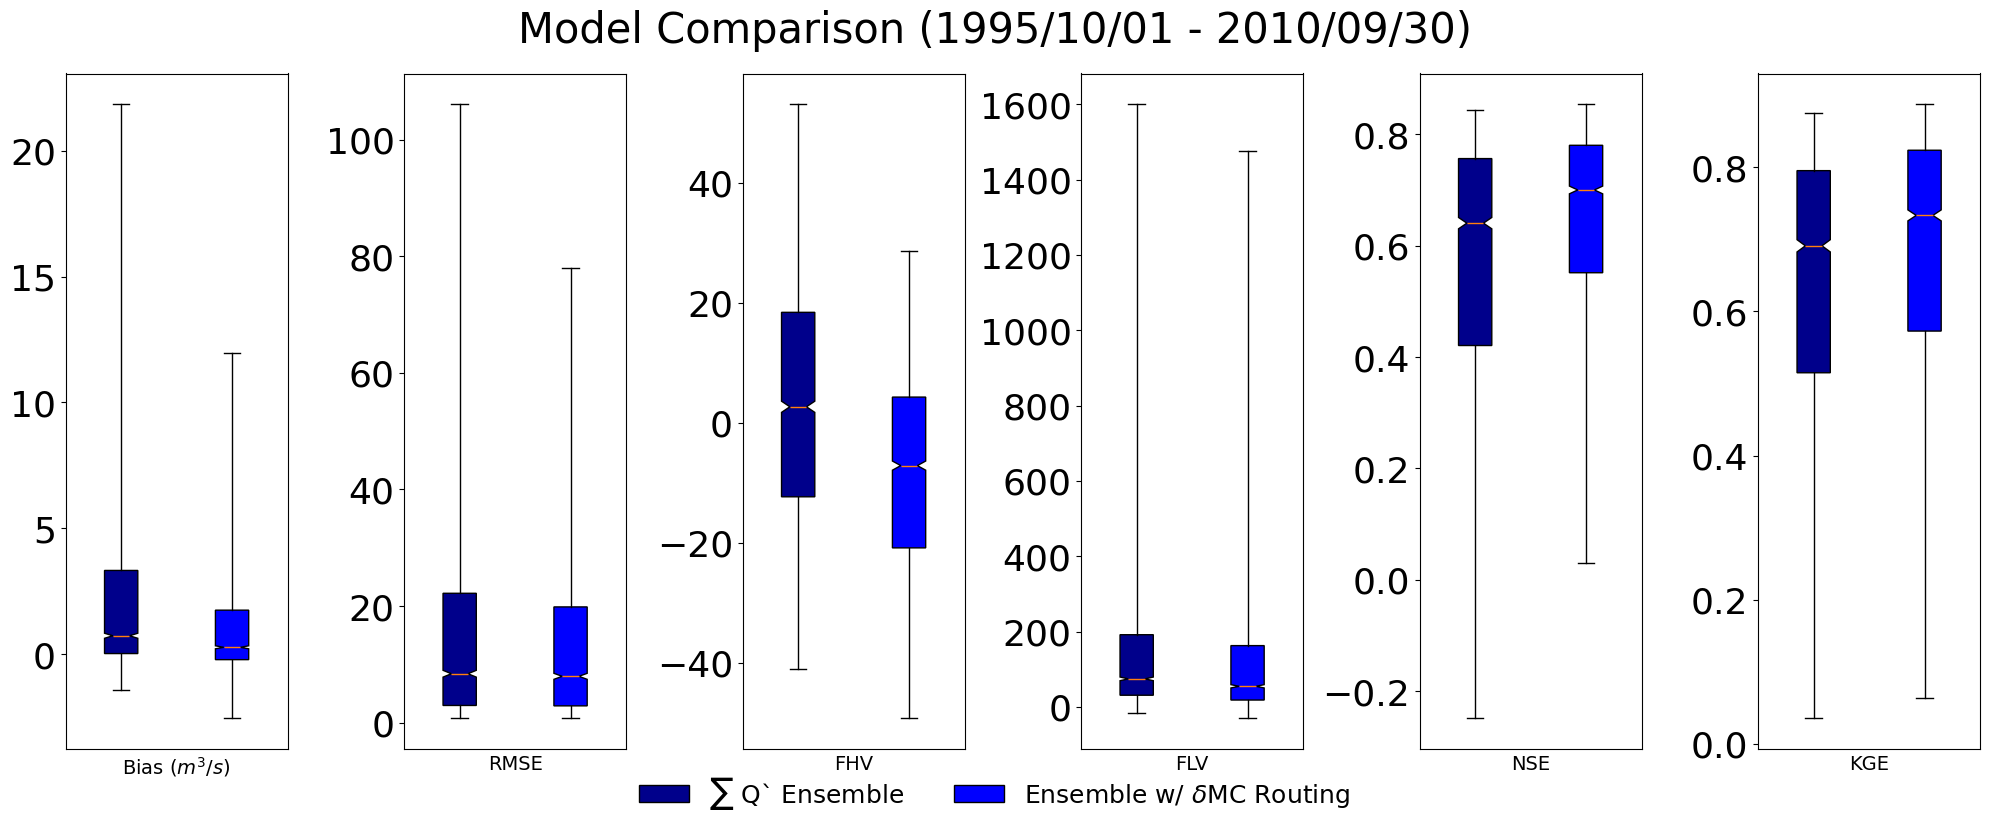

In [6]:
# Define metrics to include in the boxplot
key_list = ["bias", "rmse", "fhv", "flv", "nse", "kge"]
xlabel = [
    r"Bias ($m^3/s$)",
    "RMSE",
    "FHV",
    "FLV",
    "NSE",
    "KGE",
]
# dataset_labels = [
#     "$\\sum$ Q` $\\delta$Ensemble2.0UH",
#     # f"ddrv{__version__}",
#     "$\\delta$Ensemble2.0+$\\delta$MC",
# ]

dataset_labels = [
    f"$\\sum$ Q` {MODEL_NAME}",
    f"{MODEL_NAME} w/ $\\delta$MC Routing",
]

# Create Box Plots
data_box = []
for statStr in key_list:
    temp = []
    for result in results:
        data = dict(result)[statStr]
        if data.size > 0:  # Check if data is not empty
            if statStr == "nse" or statStr == "kge":
                data = np.clip(data, -1, 1)  # Clip NSE and KGE values to [-1, 1]
            data = data[~np.isnan(data)]  # Remove NaNs
            temp.append(data)
    data_box.append(temp)

fig = plot_box_fig(
    data=data_box,
    xlabel_list=xlabel,
    legend_labels=dataset_labels,
    sharey=False,
    figsize=(20, 8),
    legend_font_size=18,
    xlabel_font_size=14,
    tick_font_size=26,
)
fig.patch.set_facecolor("white")
boxPlotName = "Model Comparison (1995/10/01 - 2010/09/30)"
fig.suptitle(boxPlotName, fontsize=30)
plt.rcParams["font.size"] = 22

In [7]:
def plot_cdf(
    data_list: list[np.ndarray],
    ax: plt.Axes | None = None,
    title: str | None = None,
    legend_labels: list[str] | None = None,
    figsize: tuple = (8, 6),
    reference_line: str | None = "121",
    color_list: list[str] | None = None,
    xlabel: str | None = None,
    ylabel: str | None = None,
    xlim: tuple | None = None,
) -> tuple[plt.Figure | None, plt.Axes]:
    """Plot Cumulative Distribution Functions (CDFs) for a list of datasets.

    Parameters
    ----------
    data_list : list[np.ndarray]
        List of datasets to plot CDFs for
    ax : plt.Axes, optional
        Existing axes to plot on. If None, creates new figure and axes.
    title : str, optional
        Plot title
    legend_labels : list[str], optional
        Labels for the legend
    figsize : tuple, optional
        Figure size as (width, height), by default (8, 6)
    reference_line : str | None, optional
        Type of reference line to add ("121" for y=x, "norm" for Gaussian), by default "121"
    color_list : list[str], optional
        List of colors for each dataset. If None, uses default color palette.
    xlabel : str, optional
        X-axis label
    ylabel : str, optional
        Y-axis label
    show_diff : None, optional
        Parameter not used in this version, consider removing if not needed
    xlim : tuple, optional
        X-axis limits as (min, max)
    linespec : None, optional
        Parameter not used in this version, consider removing if not needed

    Returns
    -------
    tuple[plt.Figure | None, plt.Axes]
        Figure object (None if ax was provided) and axes object
    """
    fontsize=14
    ticksize=12
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=300)
    else:
        fig = None

    if color_list is None:
        color_list = [
            "darkblue",
            "blue",
            "red",
            "deepskyblue",
            "black",
            "darkred",
            "pink",
            "gray",
            "lightgray",
            "silver",
            "darkred",
            "orchid",
            "brown",
            "black",
            "darkred",
            "pink",
            "gray",
            "lightgray",
            "darkblue",
            "blue",
            "red",
            "deepskyblue",
            "black",
            "darkred",
            "pink",
            "gray",
            "lightgray",
        ]

    for i, data in enumerate(data_list):
        sorted_data = flatten_data(data)
        rank_values = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)

        median_value = np.median(sorted_data)

        if i == 1:
            median_value = 0.704
        if legend_labels is not None:
            legend_string = f"{legend_labels[i]}: (NSE={median_value:.3f})"
        else:
            legend_string = f"(NSE={median_value:.3f})"

        ax.plot(sorted_data, rank_values, label=legend_string)

    ax.grid(True)
    if title is not None:
        ax.set_title(title, loc="center", fontsize=fontsize)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if xlim is not None:
        ax.set_xlim(xlim)

    # Reference lines
    if reference_line == "121":
        ax.plot([0, 1], [0, 1], "k", label="y=x")
    elif reference_line == "norm":
        import scipy.stats

        norm_x = np.linspace(-5, 5, 1000)
        norm_cdf = scipy.stats.norm.cdf(norm_x, 0, 1)
        ax.plot(norm_x, norm_cdf, "k", label="Gaussian")

    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 1.0)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.legend(loc="best", fontsize=11)
    return fig, ax

def flatten_data(x: np.ndarray) -> np.ndarray:
    """Flatten the input data and remove NaN values.

    Parameters
    ----------
    x : np.ndarray
        Input data array

    Returns
    -------
    np.ndarray
        Sorted array with NaN values removed
    """
    return np.sort(x[~np.isnan(x)])

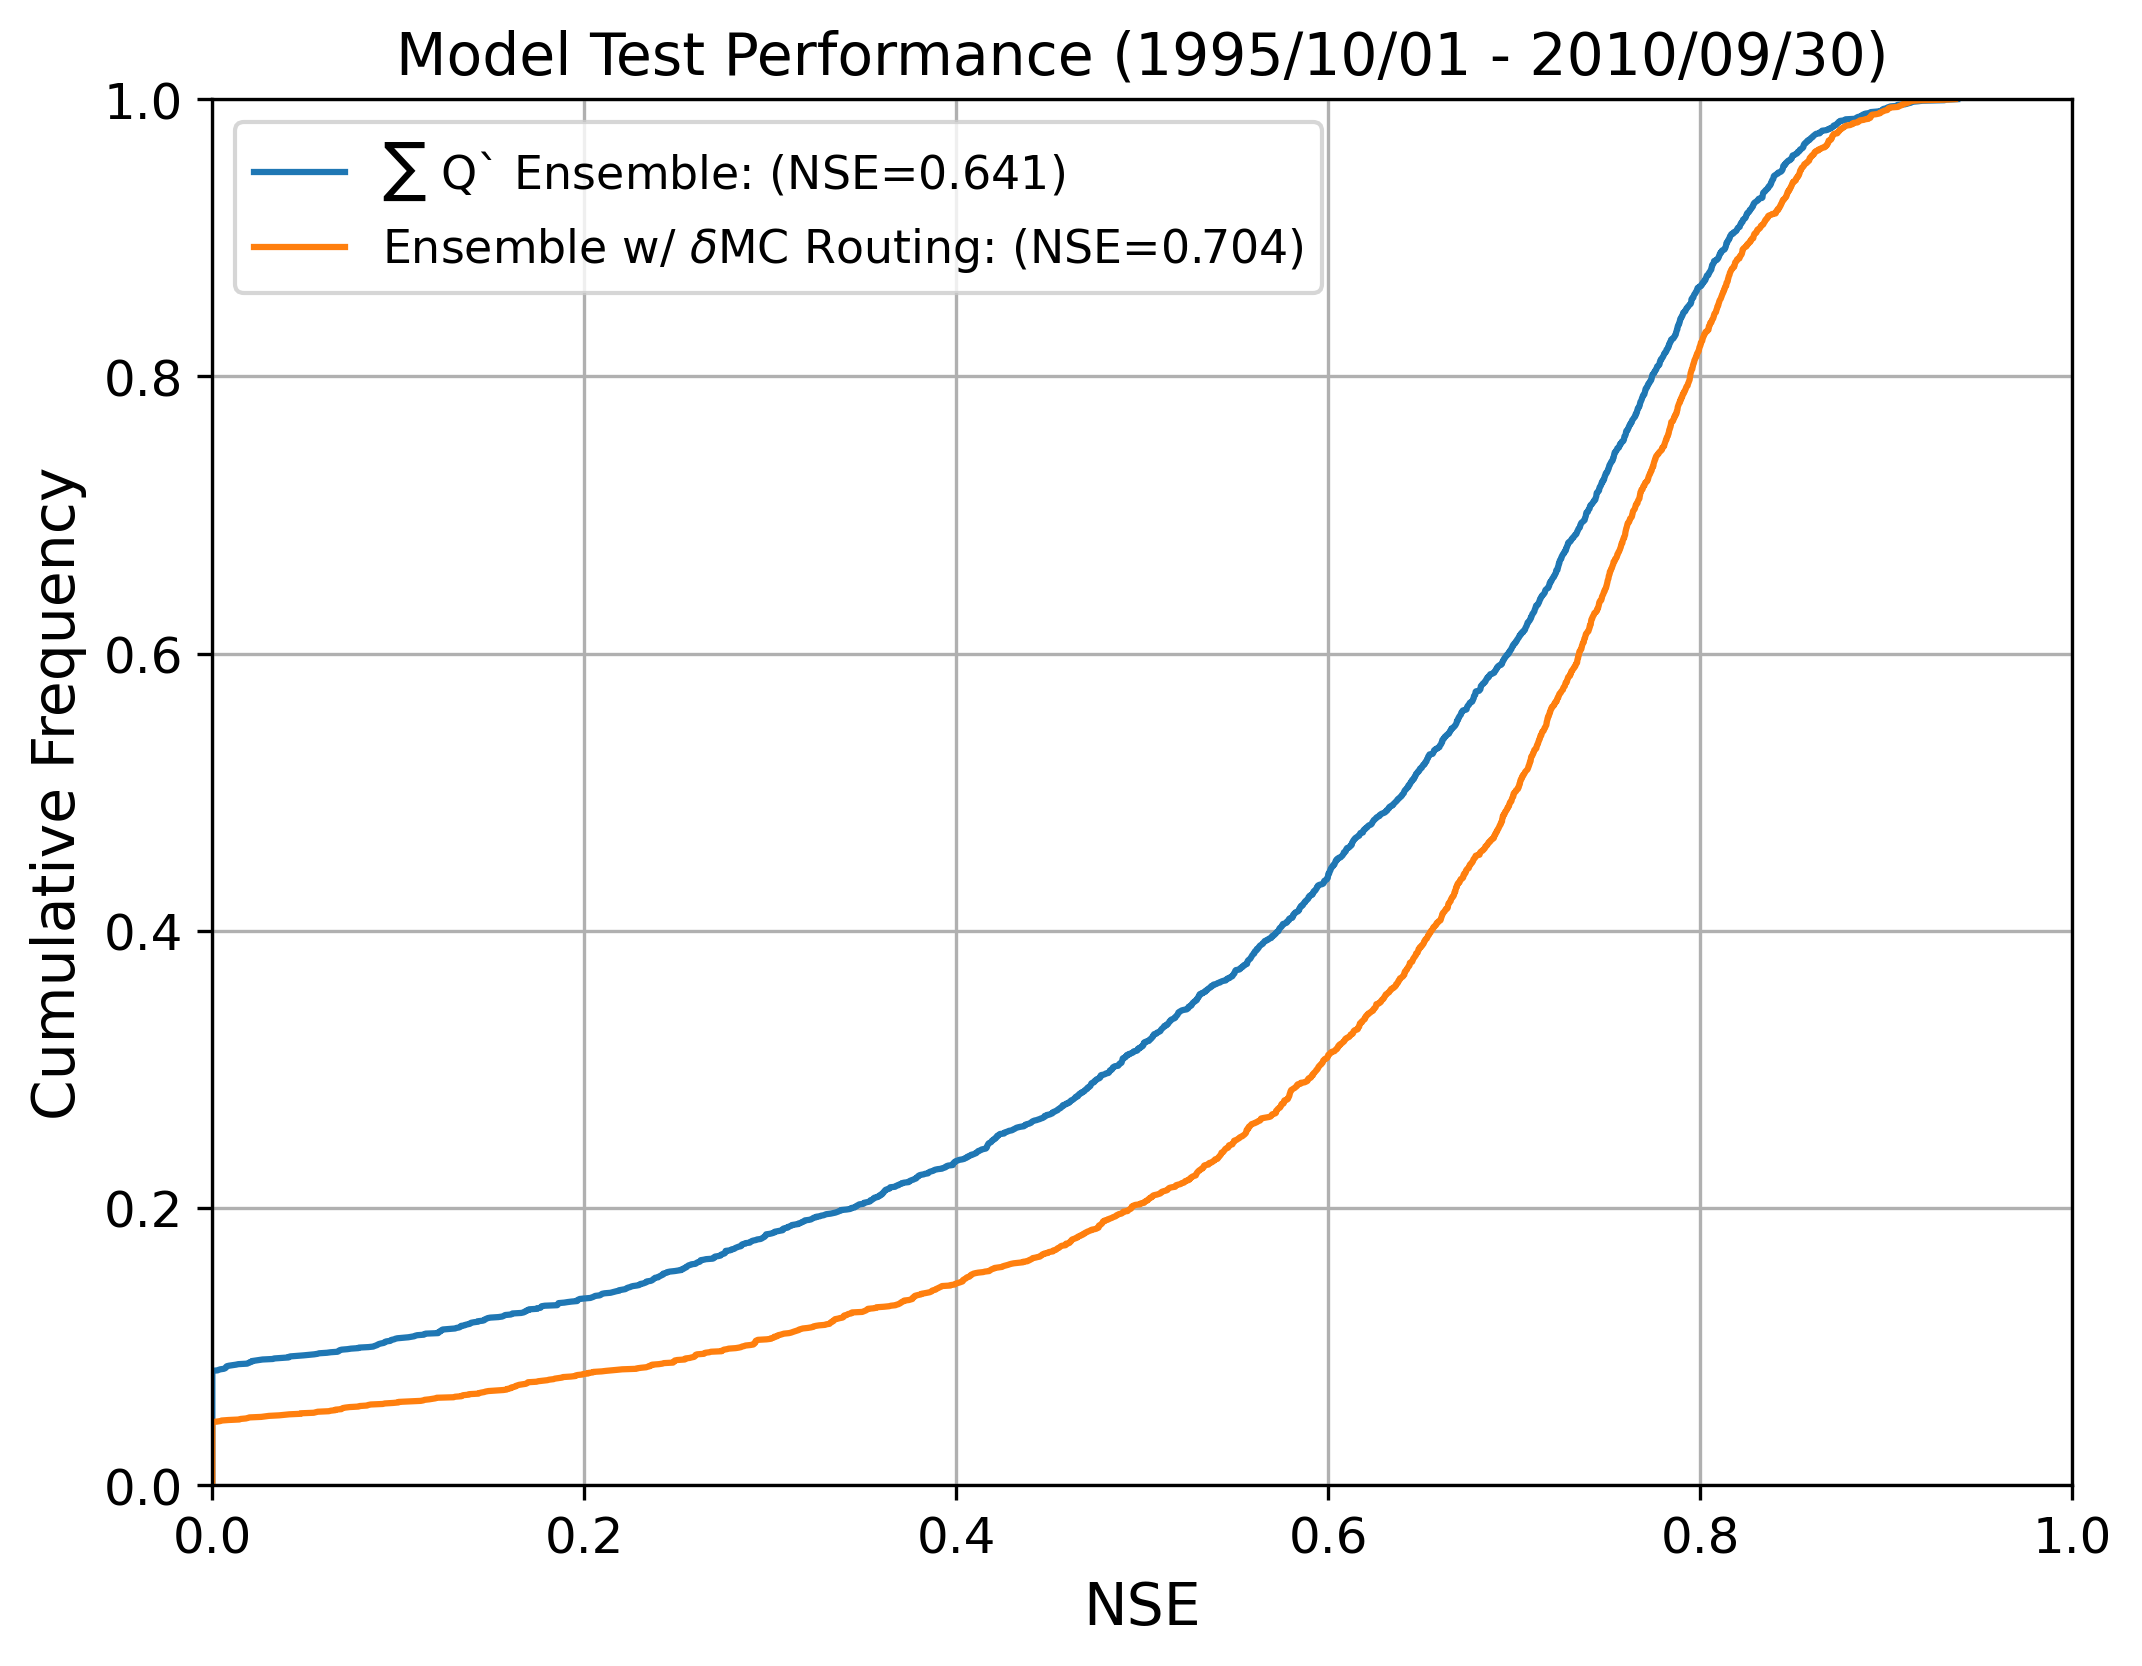

In [8]:
# Plot a CDF
fig, ax = plot_cdf(
    data_list=[np.clip(dict(result)["nse"], 0, None) for result in results],
    title="Model Test Performance (1995/10/01 - 2010/09/30)",
    legend_labels=dataset_labels,
    figsize=(8, 6),
    xlabel="NSE",
    ylabel="Cumulative Frequency",
    reference_line=None,
    color_list=["darkblue", "orange"],
)
plt.show()

In [9]:
def plot_drainage_area_boxplots(
    gages: pd.DataFrame,
    metrics: list[str],
    model_names: list[str],
    colors: list[str] | None = None,
    bins: np.ndarray | None = None,
    title: str | None = None,
    ylabel: str = "NSE",
    xlabel: str = r"Drainage area (km$^2$)",
    figsize: tuple = (18, 6),
    y_limits: tuple = (0.0, 1.0),
    path: Path | None = None,
    show_plot: bool = False,
) -> plt.Figure:
    """Create custom box plots of model performance metrics binned by drainage area.

    Parameters
    ----------
    gages : pd.DataFrame
        DataFrame containing gauge information with 'DRAIN_SQKM' column and metric columns
    metrics : list[str]
        List of column names containing the metrics to plot
    model_names : list[str]
        List of model names for the legend (supports LaTeX formatting)
    colors : list[str], optional
        Colors for each model. If None, uses default nature-inspired palette
    bins : np.ndarray, optional
        Bin edges for drainage area. If None, uses default bins
    title : str, optional
        Plot title
    ylabel : str, optional
        Y-axis label, by default "NSE"
    xlabel : str, optional
        X-axis label, by default "Drainage area (km²)"
    figsize : tuple, optional
        Figure size, by default (18, 6)
    y_limits : tuple, optional
        Y-axis limits, by default (0.0, 1.0)
    path : Path, optional
        Path to save the plot
    show_plot : bool, optional
        Whether to display the plot, by default False

    Returns
    -------
    plt.Figure
        The matplotlib figure object
    """
    # Set default colors if not provided
    if colors is None:
        colors = ["#82C6E2", "#4878D0", "#D65F5F", "#EE854A"]  # Nature-inspired palette

    # Set default bins if not provided
    if bins is None:
        bins = np.array([0, 1000, 5000, 10000, 30000, 50000])

    # Validate inputs
    if len(metrics) != len(model_names):
        raise ValueError("Number of metrics must match number of model names")

    if len(colors) < len(metrics):
        # Repeat colors if not enough provided
        colors = (colors * ((len(metrics) // len(colors)) + 1))[: len(metrics)]

    # Create area bin categories
    gages_copy = gages.copy()
    gages_copy["area_bin"] = pd.cut(gages_copy["DRAIN_SQKM"], bins, labels=False) + 1
    num_bins = len(bins) - 1

    # Update plot style for publication quality
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.size": 22,
            "axes.linewidth": 1.5,
            "axes.edgecolor": "#333333",
            "grid.alpha": 0.3,
            "grid.linestyle": "--",
            "xtick.major.width": 1.5,
            "xtick.minor.width": 1,
            "ytick.major.width": 1.5,
            "ytick.minor.width": 1,
            "xtick.direction": "out",
            "ytick.direction": "out",
            "xtick.major.size": 6,
            "ytick.major.size": 6,
        }
    )

    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True, facecolor="white", dpi=300)

    # Create labels for x-axis
    labels = [f"{int(bins[i])}~{int(bins[i + 1])}" for i in range(len(bins) - 1)]

    # Create exactly equal-sized bins for visualization
    bin_width = 5  # Width of each bin in visualization units
    bin_positions = [i * bin_width for i in range(num_bins)]  # Starting position of each bin

    # Loop through models and create boxplots
    for j, (metric, color, _model_name) in enumerate(zip(metrics, colors, model_names, strict=False)):
        model_width = bin_width / 6
        model_offset = j - (len(metrics) - 1) / 2

        data = []
        positions = []
        widths = []

        for i in range(1, num_bins + 1):
            bin_data = gages_copy[gages_copy["area_bin"] == i][metric].dropna().values
            data.append(bin_data)

            bin_center = bin_positions[i - 1] + bin_width / 2
            positions.append(bin_center + model_offset * model_width)
            widths.append(model_width * 0.8)

        _ = ax.boxplot(
            data,
            vert=True,
            showfliers=False,
            positions=positions,
            patch_artist=True,
            widths=widths,
            notch=False,  # show confidence interval around median
            boxprops={"facecolor": color, "color": "black", "alpha": 0.6, "linewidth": 1.5},
            medianprops={"color": "black", "linewidth": 2},
            whiskerprops={"color": "black", "linewidth": 1.5},
            capprops={"color": "black", "linewidth": 1.5},
        )

    # Add horizontal line at 0
    ax.axhline(0, color="red", linestyle="--", lw=1.5, alpha=0.7)

    # Subtle background grid
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.3)


    # Customize appearance and add site count text
    y_lower, y_upper = y_limits

    # Place the site count text above the plot, but slightly lower
    for i in range(1, num_bins + 1):
        num_sites = sum(gages_copy["area_bin"] == i)
        bin_center = bin_positions[i - 1] + bin_width / 2
        # Using figure-relative coordinates to adjust by pixels
        fig_height = fig.get_figheight()
        dpi = fig.dpi if fig.dpi else 100  # Default DPI if not specified
        pixel_offset_in_data = 20 / (dpi * fig_height)  # Convert 20 pixels to data units
        ax.text(
            bin_center,
            y_upper + 0.05 - pixel_offset_in_data - 0.06,
            f"{num_sites} sites",
            horizontalalignment="center",
            fontsize=20,
            color="#333333",
        )

    # Axis labels, limits, and formatting
    ax.set_ylabel(ylabel, fontsize=24, weight="bold", color="#333333")
    ax.set_xlabel(xlabel, fontsize=24, weight="bold", color="#333333")

    # ax.set_yticks(np.arange(y_lower, y_upper + 0.1, 0.5))
    ax.set_ylim([y_lower, y_upper + 0.1])  # Extra space for the site count text
    ax.tick_params(axis="y", labelsize=20)

    # Set x-axis limits
    ax.set_xlim([-0.5, num_bins * bin_width + 0.5])  # Add a bit of padding on both sides

    # Add vertical dashed lines at bin boundaries
    for i in range(num_bins + 1):
        bin_boundary = i * bin_width
        ax.axvline(bin_boundary, color="#333333", linestyle="--", lw=1.5, alpha=0.7)

    # Set x-ticks at bin centers
    bin_centers = [bin_positions[i] + bin_width / 2 for i in range(num_bins)]
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(labels, fontsize=20)

    # Create legend
    legend_handles = [
        plt.Line2D(
            [0],
            [0],
            color="#333333",
            lw=2,
            markerfacecolor=color,
            marker="s",
            markersize=10,
            label=name,
            markeredgecolor="black",
            markeredgewidth=1.5,
        )
        for name, color in zip(model_names, colors, strict=False)
    ]

    # Determine layout - use 2 columns for better spacing
    ncol = 2 if len(model_names) <= 4 else 3
    ax.legend(
        handles=legend_handles,
        loc="lower left",
        fontsize=20,
        frameon=True,
        framealpha=0.9,
        edgecolor="#E5E5E5",
        ncol=ncol,
    )

    if title:
        ax.set_title(title, fontsize=26, weight="bold", color="#333333", pad=20)

    if path:
        plt.savefig(path, dpi=300, bbox_inches="tight", facecolor="white")
        plt.close(fig)

    if show_plot:
        plt.show()

    return fig


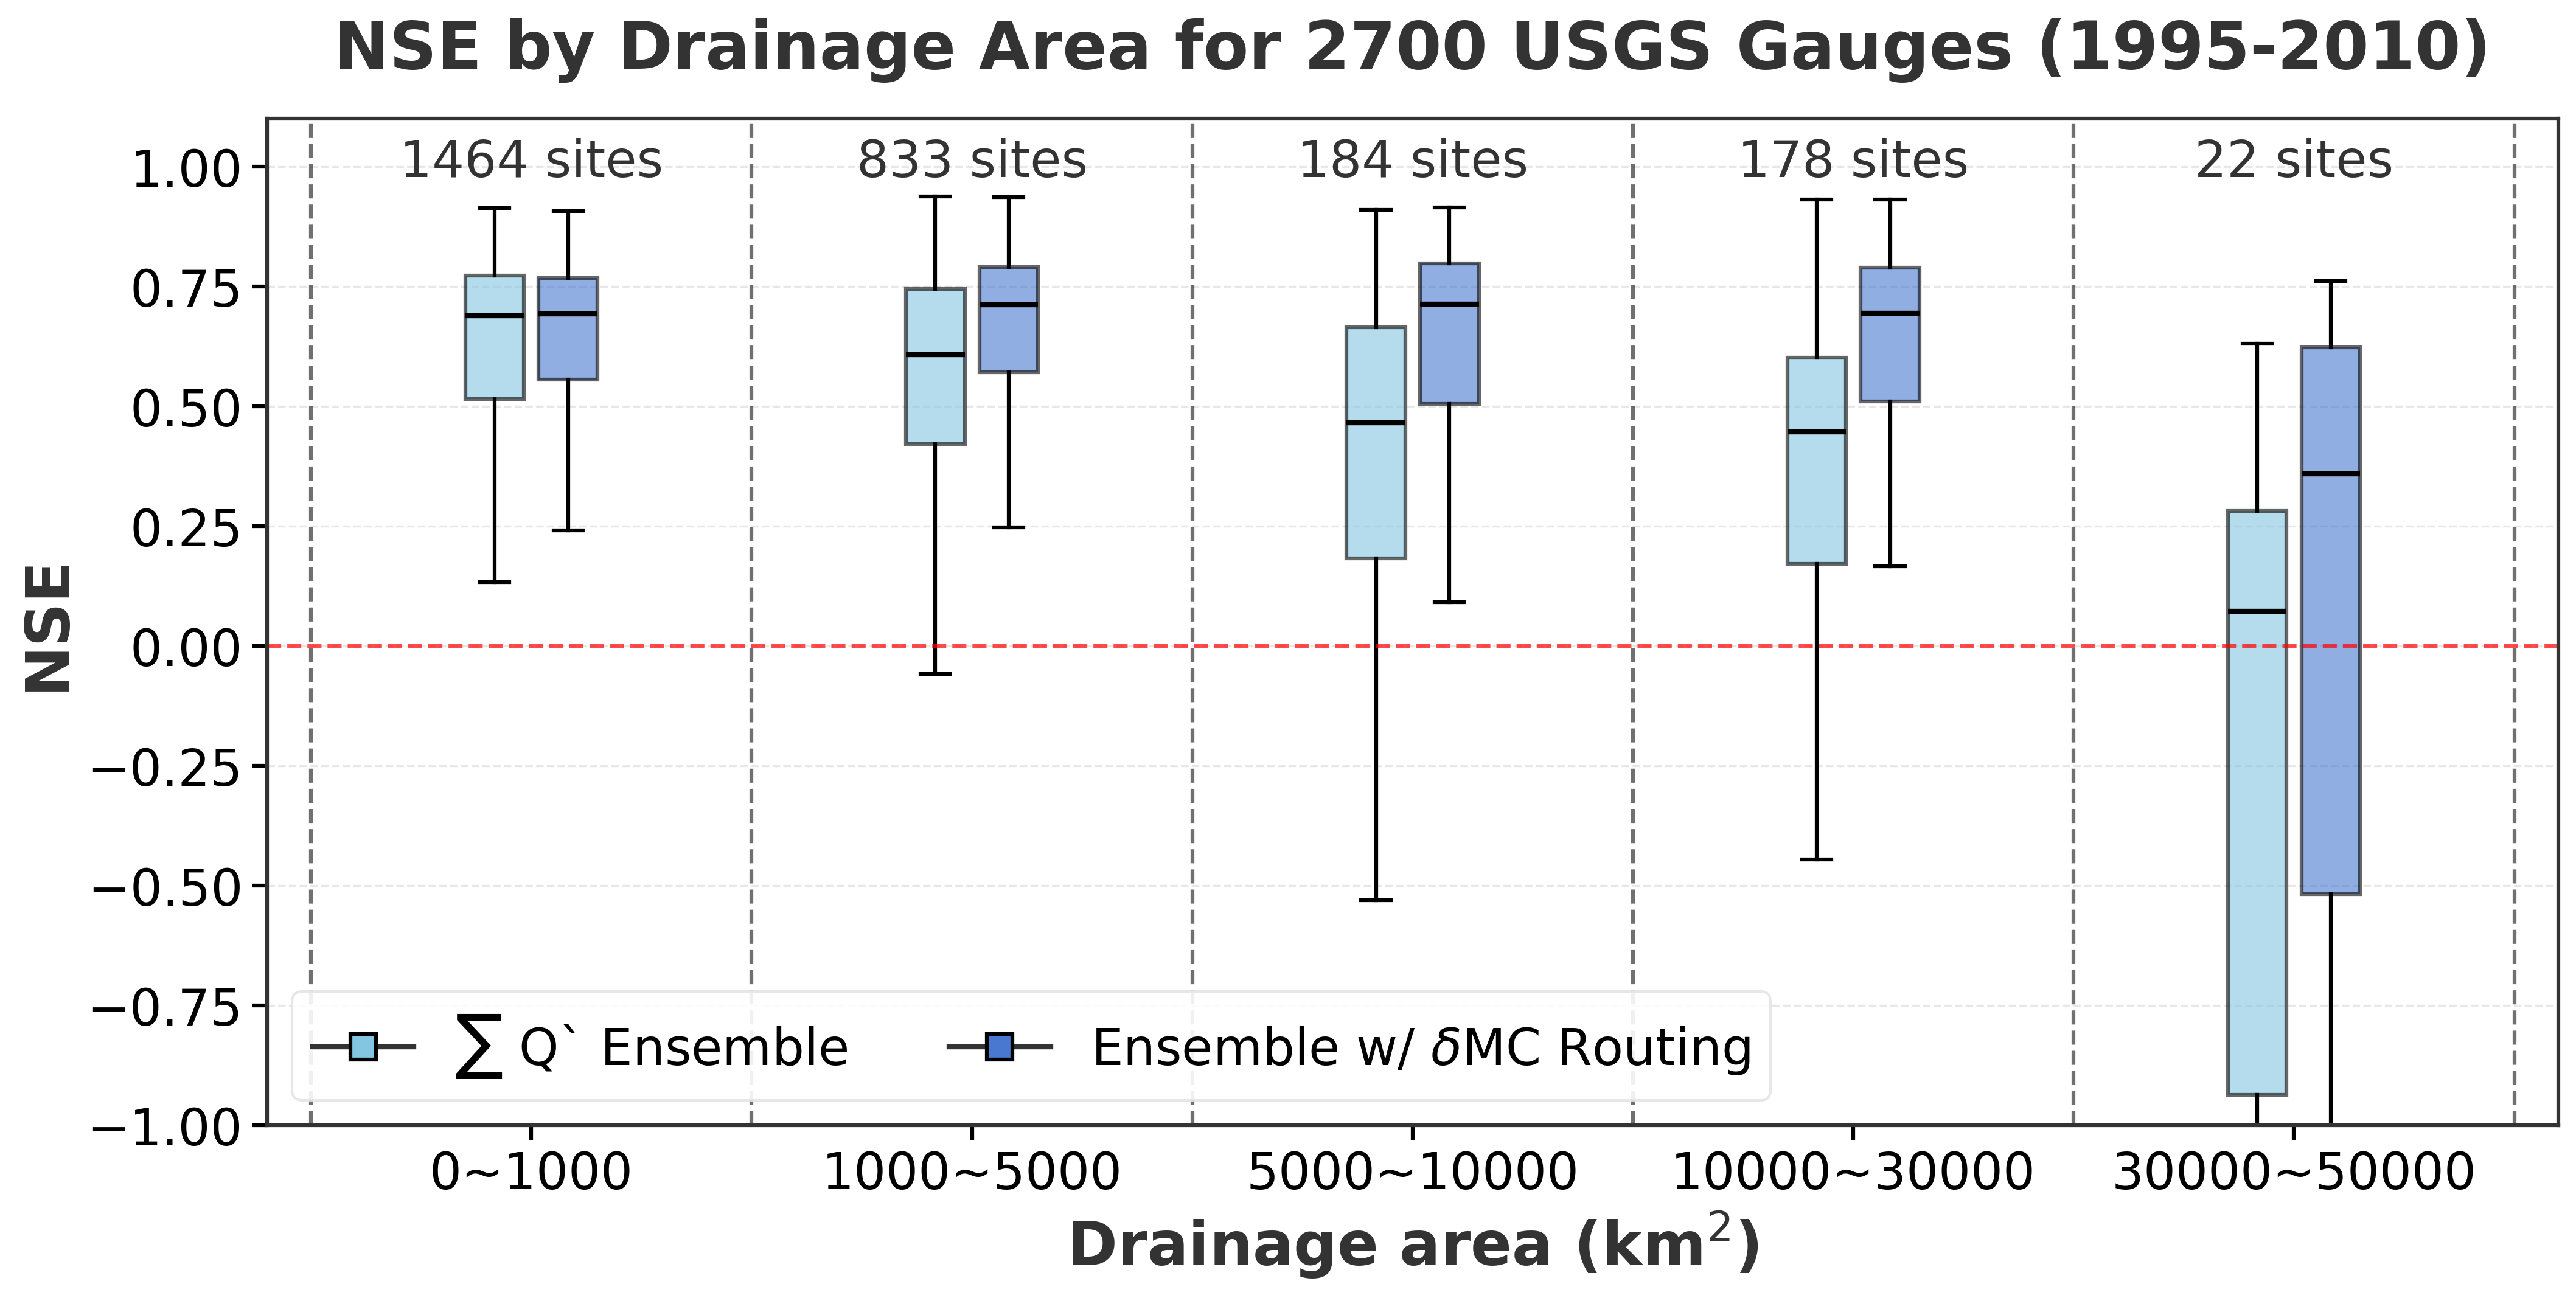

In [12]:
# If you have the gauges.csv file, you can run the following function to break up your code's performance by gauge DA
gages_df = pd.read_csv("training_gauges.csv")
gages_df["STAID"] = gages_df["STAID"].astype(str).str.zfill(8)
gages_df = gages_df.set_index("STAID")
selected_gages = gages_df.loc[ds_pred.gage_ids.values].reset_index()

selected_gages["q_prime_NSE"] = np.clip(results[0].nse, a_min=-1.0, a_max=1.0)
selected_gages["ddr_NSE"] = np.clip(results[1].nse, a_min=-1.0, a_max=1.0)

fig = plot_drainage_area_boxplots(
    figsize=(14, 7),
    gages=selected_gages,
    metrics=["q_prime_NSE", "ddr_NSE"],
    model_names=dataset_labels,
    show_plot=True,
    y_limits=(-1, 1),
    title="NSE by Drainage Area for 2700 USGS Gauges (1995-2010)",
)

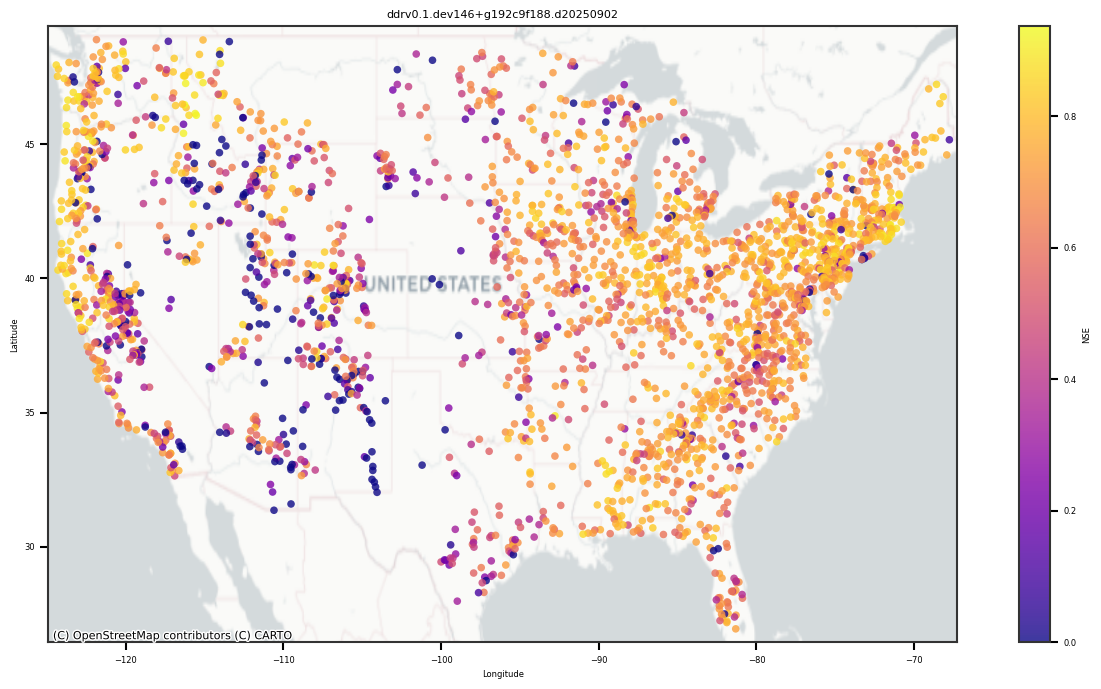

In [23]:
fig = plot_gauge_map(
    gages=selected_gages,
    metric_column="ddr_NSE",
    title=f"ddrv{__version__}",
    show_plot=True,
    colormap="plasma",
    figsize=(16, 8),
    point_size=30,
)